# Marginal Gaussianization

* Author: J. Emmanuel Johnson
* Email: jemanjohnson34@gmail.com

In this demonstration, we will show how we can do the marginal Gaussianization on a 2D dataset using the Histogram transformation and Inverse CDF Gaussian distribution. 



In [1]:
import sys
from pyprojroot import here
sys.path.append(str(here()))

from rbig.data import ToyData
from rbig.transform.gaussianization import MarginalGaussianization, Gaussianization
from rbig.transform import InverseGaussCDF
from rbig.transform.uniformization import HistogramUniformization, KDEUniformization, MarginalUniformization
from rbig.transform import InverseGaussCDF
from rbig.transform.marginal import MarginalTransformation
from rbig.transform.gaussianization import Gaussianization

import numpy as np
from scipy import stats

# Plot Functions
import matplotlib.pyplot as plt
import seaborn as sns

sns.reset_defaults()
#sns.set_style('whitegrid')
#sns.set_context('talk')
sns.set_context(context='talk',font_scale=0.7)
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Data

For this example, we are looking at a 2D dataset.

In [ ]:
def plot_2d_joint(data, color='blue', title='Original Data'):
    
    fig  = plt.figure(figsize=(5, 5))

    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='hex', color=color)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    
def plot_prob(data, probs, title='Probabilities'):
    
    fig, ax = plt.subplots()

    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap='Reds')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    cbar = plt.colorbar(h, )
    ax.set_title(title)
    plt.show()

In [ ]:
seed = 123
n_samples = 10_000
a = 4

# initialize data distribution
data_dist = stats.gamma(a=a)
plot = np.linspace(0.1, 15, 100)
# get some samples
X_ = data_dist.rvs(size=(n_samples, 1), random_state=seed)
X_lprob_  = data_dist.logpdf(plot)
# plot distribution
sns.distplot(X_);
plt.show()

# plot distribution
sns.distplot(X_lprob_);
plt.show()

## 1D Transformation

For this first example, we're going to look at how we can combine the uniformization transformation and the inverse Gaussian CDF transformation

In [39]:
# # subset a 1D part of the data
# X = data[:, 0].reshape(-1, 1)
X = X_.copy()

print(X.shape)
# 1 - uniform transformation
uni_transformer = HistogramUniformization()
uni_transformer = KDEUniformization(method='exact', n_quantiles=50)

# initialize gaussianization transform
gauss_transformer = Gaussianization(uni_transformer)

gauss_transformer.fit(X)

(10000, 1)


Gaussianization(uni_transformer=KDEUniformization(algorithm='kd_tree',
                                                  bw_method='scott',
                                                  interp=True,
                                                  kernel='gaussian', kwargs={},
                                                  method='exact',
                                                  metric='euclidean',
                                                  n_quantiles=50, norm=2,
                                                  support_extension=10))

### Forward Transformation

For this transformation, we will be applying the following:

$$\Psi(\mathbf{x}) = \Phi^{-1}(\mathbf{x})$$

where $\Phi^{-1}(\cdot)$ is the inverse CDF of the Gaussian distribution.

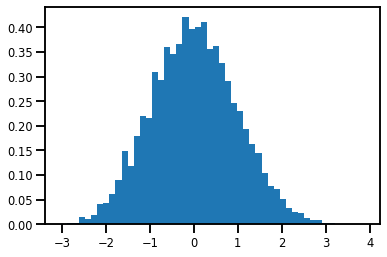

In [40]:

X_g = gauss_transformer.transform(X)


# plot the two distributions
fig, ax = plt.subplots()
ax.hist(X_g, bins=50, density=True);

### 2. Inverse Transformation

For this step, we will apply the inverse transformation:

$$\Psi^{-1}(\mathbf{x}) = \Phi \left( \mathbf{x} \right)$$

where $\Phi(\cdot)$ is the CDF of the Gaussian distribution.

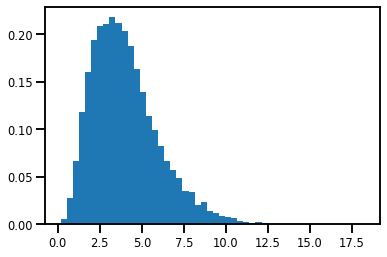

In [41]:
X_approx = gauss_transformer.inverse_transform(X_g)

fig, ax = plt.subplots()
ax.hist(X_approx, bins=50, density=True);

### Log Determinant Jacobian

Using the derivative of inverse-functions theorem, we can calculate the derivative like so:

$$\nabla_\mathbf{x} \Phi^{-1}(\mathbf{x}) = \frac{1}{\phi (\Phi^{-1} (x)) }$$

where $\phi(\cdot)$ is the PDF of the Gaussian distribution. Taking the log of these terms gives us:

$$ \log \nabla_\mathbf{x} \Phi^{-1}(\mathbf{x}) = - \log \phi (\Phi^{-1} (x))$$

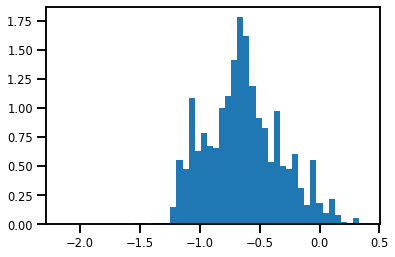

In [42]:
X_ldj = gauss_transformer.log_abs_det_jacobian(X)



fig, ax = plt.subplots()
ax.hist(X_ldj, bins=50, density=True);
plt.show()

### Probability

This is the same as above but without the log scale:

$$p_\theta(\mathbf{x}) = p_\theta \left( \mathbf{z} \right) \left| \nabla_\mathbf{x} \mathbf{z} \right|$$

where $\mathbf{z} = \Psi(\mathbf{x})$

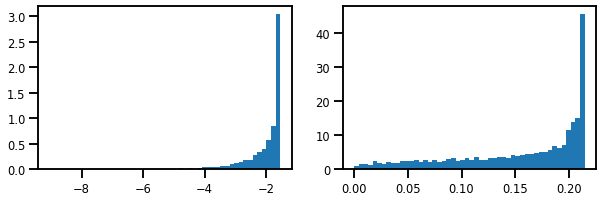

In [43]:
X_lprob = gauss_transformer.score_samples(X)


fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].hist(X_lprob, bins=50, density=True);
ax[1].hist(np.exp(X_lprob), bins=50, density=True);
plt.show()

### Negative Log-Likelihood

We need to take the expected value (mean) of all log probabilities.

$$\text{nll} = \frac{1}{N} \sum_{n=1}^{N} \log p_\theta(\mathbf{x})$$

In [44]:
gauss_transformer.score(X)

X_nll = gauss_transformer.score(X)

print(f"Negative Log-Likelihood Score: {X_nll:.4f}")

Negative Log-Likelihood Score: -2.0255


### Wrapper

We have a convenience function called "=`gaussianization` that will do the inverse Gauss CDF for us. That way we don't have to worry about stringing the operations together. Especially the derivative, which can be tricky sometimes.

## Marginal Gaussnaization

<Figure size 360x360 with 0 Axes>

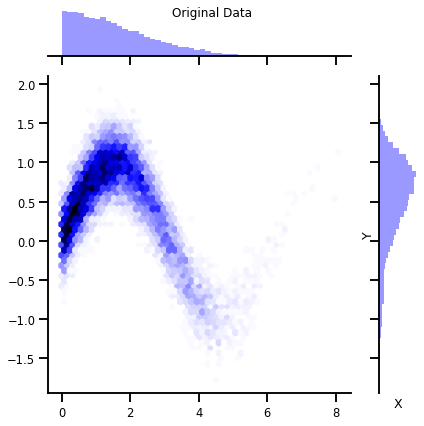

In [7]:
seed = 123
rng = np.random.RandomState(seed=seed)
dataset = 'rbig'
n_samples = 10_000
n_features = 2
noise = 0.25
random_state=1
clusters = 2


data = ToyData(
    dataset=dataset, 
    n_samples=n_samples, 
    n_features=n_features, 
    noise=noise, 
    random_state=random_state,
    clusters=clusters,
).generate_samples()

X = data[:, 0]
Y = data[:, 1]

plot_2d_joint(data, title='Original Data')

<Figure size 360x360 with 0 Axes>

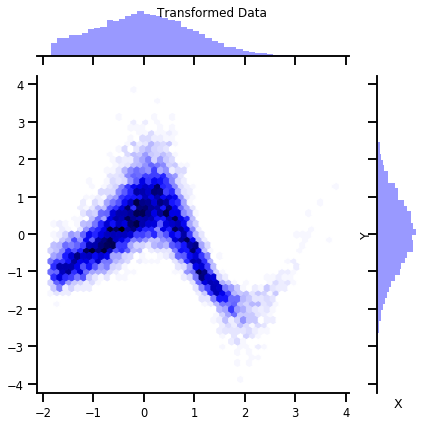

In [24]:
# subset a 1D part of the data
X = data.copy()


# 1 - uniform transformation
# uniform_transformer = HistogramUniformization(bins=50)
uniform_transformer = KDEUniformization(method='exact', n_quantiles=50)

gauss_transformer = Gaussianization(uni_transformer=uniform_transformer)

marginal_transformer = MarginalGaussianization(gauss_transformer)

marginal_transformer.fit(X)

X_trans = marginal_transformer.transform(X)

plot_2d_joint(X_trans, title='Transformed Data')

<Figure size 360x360 with 0 Axes>

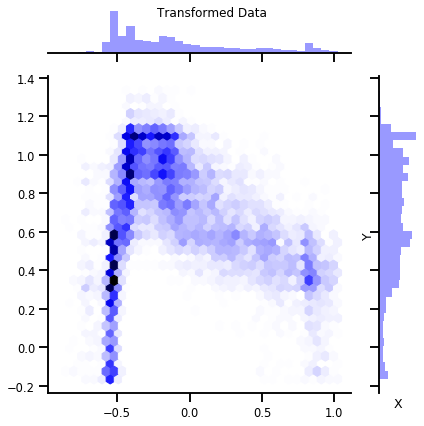

<Figure size 360x360 with 0 Axes>

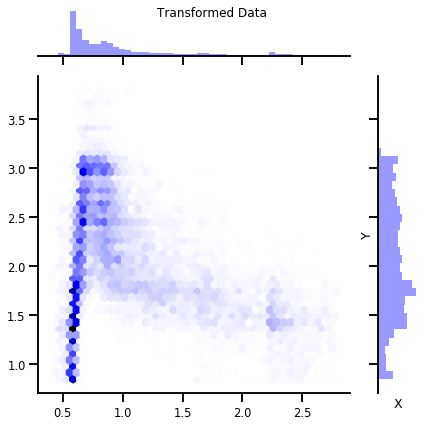

In [25]:
X_ldj = marginal_transformer.log_abs_det_jacobian(data)

plot_2d_joint(X_ldj, title='Transformed Data')
plot_2d_joint(np.exp(X_ldj), title='Transformed Data')

### Probabilities

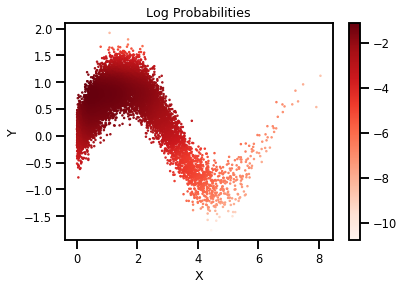

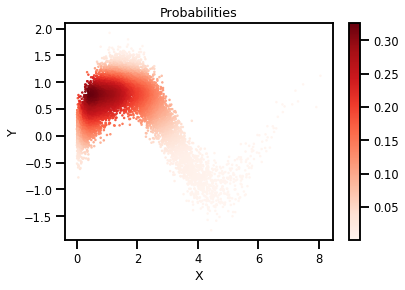

In [26]:
# calculate real log probability of distribution
x_prob = marginal_transformer.score_samples(data)

plot_prob(data, x_prob, title='Log Probabilities')
plot_prob(data, np.exp(x_prob), title='Probabilities')

### Negative Log Likelihood

In [23]:
X_nll = marginal_transformer.score(data)

print(f"Negative Log-Likelihood Score: {X_nll:.4f}")

Negative Log-Likelihood Score: -2.1591


In [27]:
X_nll = marginal_transformer.score(data)

print(f"Negative Log-Likelihood Score: {X_nll:.4f}")

Negative Log-Likelihood Score: -2.1902


### 1. Forward Transformation



<Figure size 360x360 with 0 Axes>

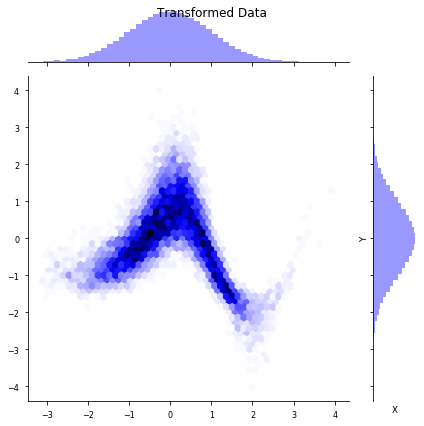

In [6]:
data_trans = mg_transformer.transform(data)

plot_2d_joint(data_trans, title='Transformed Data')

So clearly we can see that the transformation works. Both of the marginals are Gaussian distributed..

### 2. Inverse Transformation



In [7]:
data_approx = mg_transformer.inverse_transform(data_trans)

# check that its more or less equal
np.testing.assert_array_almost_equal(data_approx, data, decimal=1e-5)

We see that this transformation is very close to the original. In fact, it's close to approximately 1e-5 decimal places. The errors will definitely stem from the boundaries.

<Figure size 360x360 with 0 Axes>

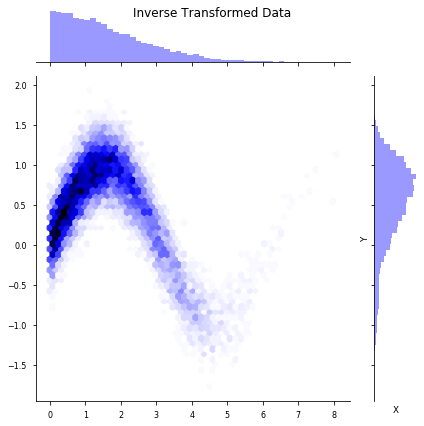

In [8]:
# Plot results
plot_2d_joint(data_approx, title='Inverse Transformed Data')

## Log Absolute Determinant Jacobian





In [9]:
X_slogdet = mg_transformer.log_abs_det_jacobian(data)

print(X_slogdet.min(), X_slogdet.max())
print(np.exp(X_slogdet).min(), np.exp(X_slogdet).max())

(-2.459695595900522, 5.0787933667391965)

(0.08546096167531662, 160.5801775987935)

<Figure size 360x360 with 0 Axes>

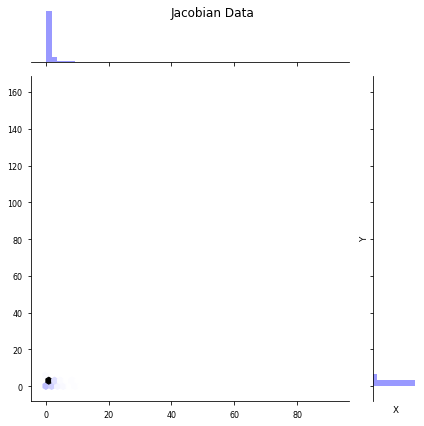

In [12]:
# plot the gradients
plot_2d_joint(np.exp(X_slogdet), title='Jacobian Data')

## Log Probability

$$\log p_\theta(\mathbf{x}) = \log p_\theta \left( \mathbf{z} \right) + \log \left| \nabla_\mathbf{x} \mathbf{z} \right|$$

where $\mathbf{z} = \Psi(\mathbf{x})$


In [13]:
# score samples 
log_prob = mg_transformer.score_samples(data)

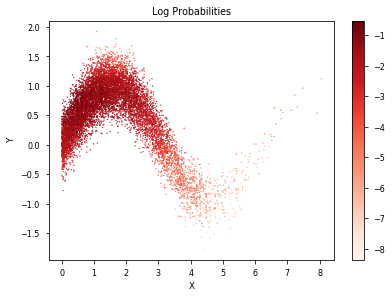

In [14]:
# score samples 
log_prob = mg_transformer.score_samples(data)

plot_prob(data, log_prob, title='Log Probabilities')